In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import pandas as pd
import cv2
import os
import math

image = plt.imread("greenscreen.jpg")
cat =plt.imread("cat.jpg")
cat_background = cat[130:505,200:700,:]
minHessian = 400
surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
orb = cv2.ORB_create()
semper0 = plt.imread("semper0.jpg")
semper1 = plt.imread("semper1.jpg")

# Question 1
# Get mask where green is in the threshold and also
# where greens are smaller than either of the other colours
mask = (image[:, :, 1] < 175) | (image[:, :, 2] > image[:, :, 1]) | (image[:, :, 0] > image[:, :, 1])
# Get Inverse mask
un_mask = np.invert(mask)
green = np.zeros_like(image, np.uint8)
green[mask] = image[mask]
def display_1():
    green[un_mask] = cat_background[un_mask]
    plt.axis('off')
    plt.imshow(green)
    
# Question2
grey= Image.open('lena_gray.gif').convert("L")
grey = np.asarray(grey).astype(float)
# Blur image
smoothed_grey = ndimage.gaussian_filter(grey, sigma=(2))
mask = grey - smoothed_grey
masked = grey + mask
smoothed_grey = smoothed_grey.astype(np.uint8)
grey = grey.astype(np.uint8)
mask = mask.astype(np.uint8)
masked_clipped = np.clip(masked, 0, 255)
masked_scaled = ((masked*1.0)/(np.max(masked)) * 255).astype(np.uint8)
masked = masked.astype(np.uint8)

# display question 2
def display_2():
    plt.axis('off')
    print("Original picture:")
    plt.imshow(grey, cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Smoothed with Gaussian filter:")
    plt.imshow(smoothed_grey,cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Mask:")
    plt.imshow(mask,cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Final Result Truncated:")
    plt.imshow(masked,cmap='gray')
    plt.show()
    plt.axis('off')
    print("Final Result Scaled:")
    plt.imshow(masked_scaled,cmap='gray')
    plt.show()
    plt.axis('off')
    print("Final Result Clipped:")
    plt.imshow(masked_clipped,cmap='gray')
    plt.show()


# Question 3
def nn_resize(base_image, scale):
    print("Starting Nearest Neighbour")
    x_scale = int(scale*base_image.shape[0])
    y_scale = int(scale*base_image.shape[1])
    resized = np.zeros((x_scale,y_scale,3),  dtype=np.uint8)
    for x in range(0, x_scale):
        for y in range(0, y_scale):
            x_old = int(round(x/scale))
            if x_old >= base_image.shape[0] - 1:
                x_old = base_image.shape[0] - 1
            y_old = int(round(y/scale))
            if y_old >= base_image.shape[1] - 1:
                y_old = base_image.shape[1] - 1
                
            resized[x, y, :] =  base_image[x_old,y_old,:]
            
    print("Done resizing")
    return resized

def display_3_nn():
    # Enlarge
    print("Scale = 3.1")
    large_nn = nn_resize(cat, 3.1)
    cat_nn = large_nn
    plt.imshow(large_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Enlarge more
    print("Scale = 5")
    large_nn = nn_resize(cat, 5)
    plt.imshow(large_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink
    print("Scale = 0.9")
    small_nn = nn_resize(cat, 0.9)
    plt.imshow(small_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink more
    print("Scale = 0.1")
    small_nn = nn_resize(cat, 0.1)
    plt.imshow(small_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    return cat_nn

def bl_resize(base_image, scale):
    print("Starting Bilinear Interpolation")
    x_scale = int(scale * base_image.shape[0])
    y_scale = int(scale * base_image.shape[1])
    resized = np.zeros((x_scale, y_scale, 3), dtype=np.uint8)
    for x in range(0, x_scale):
        for y in range(0, y_scale):
            x_old = x / scale
            if x_old >= base_image.shape[0] - 1:
                x_old = base_image.shape[0] - 1
            y_old = y / scale
            if y_old >= base_image.shape[1] - 1:
                y_old = base_image.shape[1] - 1
            xf = int(floor(x_old))
            xc = int(ceil(x_old))
            yf = int(floor(y_old))
            yc = int(ceil(y_old))
            c_ff = base_image[xf, yf, :].astype(dtype=int)
            c_cf = base_image[xc, yf, :].astype(dtype=int)
            c_fc = base_image[xf, yc, :].astype(dtype=int)
            c_cc = base_image[xc, yc, :].astype(dtype=int)
            if y_old == yc and x_old == xc:
                # color is the same        
                resized[x, y, :] = base_image[xc,yc,:]
            elif y_old == yc:
                resized[x, y, :] = (
                    0.5*
                    ((xc-x_old)*c_ff + (x_old - xf)*c_cf)
                    +
                    0.5*
                    ((xc-x_old)*c_fc + (x_old - xf)*c_cc)
                ).astype(np.uint8)
            elif x_old == xc:
                # Same x
                resized[x, y, :] = (
                    (yc - y_old)*
                    (0.5*c_ff + 0.5*c_cf)
                    +
                    (y_old -yf)*
                    (0.5*c_fc + 0.5*c_cc)
                ).astype(np.uint8)
            else:
                # Same y
                resized[x, y, :] = (
                    (yc - y_old)*
                    ((xc-x_old)*c_ff + (x_old - xf)*c_cf)
                    +
                    (y_old -yf)*
                    ((xc-x_old)*c_fc + (x_old - xf)*c_cc)
                ).astype(np.uint8)
    print("Done resizing")
    return resized

def display_3_bl():
    # Enlarge
    print("Scale = 3.1")
    large_bl = bl_resize(cat, 3.1)
    cat_bl = large_bl
    plt.imshow(large_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Enlarge more
    print("Scale = 5")
    large_bl = bl_resize(cat, 5)
    plt.imshow(large_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink
    print("Scale = 0.9")
    small_bl = bl_resize(cat, 0.9)
    plt.imshow(small_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink more
    print("Scale = 0.1")
    small_bl = bl_resize(cat, 0.1)
    plt.imshow(small_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    return cat_bl

def compare_nn_bl():
    print("Nearest Neighbour Interpolation:")
    plt.imshow(cat_nn[600:610, 2100:2110, :])
    plt.show()
    print("Bilinear Interpolation:")
    plt.imshow(cat_bl[600:610, 2100:2110, :])
    plt.show()
    print("Open CV resize:")
    plt.imshow(cv2.resize(cat,None,fx=3.1,fy=3.1)[600:610, 2100:2110, :])
    plt.show()

# Question 4

# Sources
# https://www.kaggle.com/wesamelshamy/tutorial-image-feature-extraction-and-matching
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
# https://docs.opencv.org/3.4.2/d5/dde/tutorial_feature_description.html
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

def detect_colour(detector, image):
    key_points, descriptors = detector.detectAndCompute(image, None)
    return image, key_points, descriptors
    
def get_matches_orb(detector, image1, image2, nmatches=2000):
    image1, key_points_1, descriptors_1 = detect_colour(detector, image1)
    image2, key_points_2, descriptors_2 = detect_colour(detector, image2)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    print("Matching features: {}".format(len(matches)))
    matches = sorted(matches, key = lambda x: x.distance)
    image_matches = image1
    for i in range(0, len(matches[:nmatches])):
        start = key_points_1[matches[i].queryIdx].pt;
        start = (int(round(start[0])), int(round(start[1])))
        end = key_points_2[matches[i].trainIdx].pt;
        end = (int(round(end[0])), int(round(end[1])))
        cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
        cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    plt.axis("off")
    plt.imshow(image_matches)  
    plt.show()

def get_matches_surf(detector, image1, image2, nmatches=5000):
    image1, key_points_1, descriptors_1 = detect_colour(detector, image1)
    image2, key_points_2, descriptors_2 = detect_colour(detector, image2)
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)
    matches = matcher.match(descriptors_1, descriptors_2)
    print("Matching features: {}".format(len(matches)))
    matches = sorted(matches, key = lambda x: x.distance)
    image_matches = image1
    for i in range(0, len(matches[:nmatches])):
        start = key_points_1[matches[i].queryIdx].pt;
        start = (int(round(start[0])), int(round(start[1])))
        end = key_points_2[matches[i].trainIdx].pt;
        end = (int(round(end[0])), int(round(end[1])))
        cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
        cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    plt.axis("off")
    plt.imshow(image_matches)    
    plt.show()
    
def diff_algs():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, 300)
    print("ORB")
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    get_matches_orb(orb, semper0, semper1, 300)

def change_hessian(show_vecs=100):
    minHessian = 400
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 300
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 200
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 100
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 50
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

def display_4_1():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    get_matches_surf(surf, semper0, semper1, 500)

def display_4_2():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    diff_algs()
    
# Question 5

def get_matches_surf_scaled(detector, image1, image2, nmatches=5000, scale=1):
    threshold = max(image1.shape)/100.0
    correct_matches = 0
    image1, key_points_1, descriptors_1 = detect_colour(detector, image1)
    image2, key_points_2, descriptors_2 = detect_colour(detector, image2)
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)
    
    # Match one-to-one
    if len(key_points_2) < len(key_points_1):
        matches = matcher.match(descriptors_2, descriptors_1)
        matches = sorted(matches, key = lambda x: x.distance)
        image_matches = image1
        
        for i in range(0, len(matches[:nmatches])):
            start = key_points_1[matches[i].trainIdx].pt;
            start = (int(round(start[0])), int(round(start[1])))
            end = key_points_2[matches[i].queryIdx].pt;
            org_x = end[0]/scale
            org_y = end[1]/scale
            end = (int(round(org_x)), int(round(org_y)))
            dist = math.sqrt((start[0] - end[0]*1.0)**2 + (start[1] - end[1]*1.0)**2)
            if dist <= threshold:
                correct_matches += 1
            cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
            cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    else:
        matches = matcher.match(descriptors_1, descriptors_2)
        matches = sorted(matches, key = lambda x: x.distance)
        image_matches = image1
        for i in range(0, len(matches[:nmatches])):
            start = key_points_1[matches[i].queryIdx].pt;
            start = (int(round(start[0])), int(round(start[1])))
            end = key_points_2[matches[i].trainIdx].pt;
            org_x = end[0]/scale
            org_y = end[1]/scale
            end = (int(round(org_x)), int(round(org_y)))
            dist = math.sqrt((start[0] - end[0]*1.0)**2 + (start[1] - end[1]*1.0)**2)
            if dist <= threshold:
                correct_matches += 1
            cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
            cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    repeatability = float(len(matches))/len(key_points_1)
    plt.axis("off")
    plt.imshow(image_matches)
    plt.show()
    accuracy = 0.0
    accuracy = (correct_matches*1.0)/len(matches)
    print("1% distance threshold: {}".format(threshold))
    print("Matching features: {}".format(len(matches)))
    print("Correct Matches: {}".format(correct_matches))
    return len(matches), repeatability, accuracy

def resize_5():
    minHessian = 100
    arc = plt.imread("arc.jpg")
    arc_scale = []
    scales = np.arange(0.1, 3.1, 0.1)
    print("Resizing:")
    for scale in scales:
        arc_scale.append(cv2.resize(arc,None,fx=scale,fy=scale))
    placeholder = []
    for scale in arc_scale:
        placeholder.append(scale)
    return placeholder, scales

def display_5():
    placeholder, scales = resize_5()
    arc_scale = []
    repeatability_list = []
    accuracy_list = []
    for scale in placeholder:
        arc_scale.append(scale)
    for i in range(0, len(scales)):
        base = plt.imread("arc.jpg")
        new = arc_scale[i]
        matches, repeatability, accuracy = get_matches_surf_scaled(surf, base, new, scale=scales[i])
        print("Scale: {}".format(scales[i]))
        print("Repeatability:{}%\nAccuracy: {}%\n**************".format(repeatability*100, accuracy*100))
        repeatability_list.append(repeatability)
        accuracy_list.append(accuracy)
        plt.show()
    return accuracy_list, repeatability_list, scales

def plot_5():
    plt.plot(scales, accuracy_list, label="Accuracy")
    plt.plot(scales, repeatability_list, label="Repeatability")
    plt.legend()
    plt.show()
    plt.plot(scales, accuracy_list, label="Accuracy")
    plt.legend()
    plt.show()
    plt.plot(scales, repeatability_list, label="Repeatability")
    plt.legend()
    plt.show()

# Computer Vision Assignment 1
**Michael Shepherd - 19059019**
## Question 1

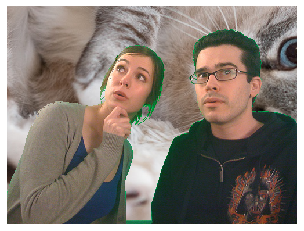

In [2]:
display_1()

To answer this question, I created a boolean mask to denote where the green value of a pixel was greater than 175 or the green value was bigger than either the blue or red value. I the created a new empty image on which I projected the greenscreen image where green was false and a new image where green was true. After some testing, I decided that this threshold was the best that I would find as it removes most of the greenscreen while still keeping most of the people infront of the greenscreen. Any difference in the threshold would either remove the shoulder of the woman or increase the amount of greenscreen left over.

## Question 2

Original picture:


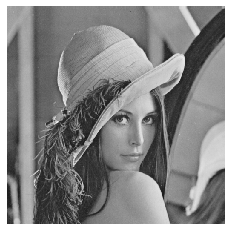

Smoothed with Gaussian filter:


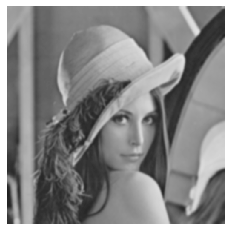

Mask:


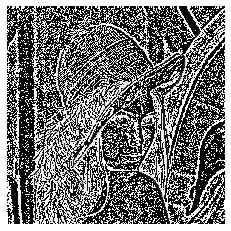

Final Result Truncated:


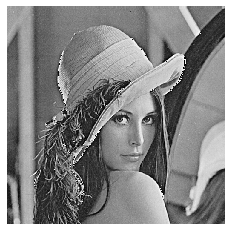

Final Result Scaled:


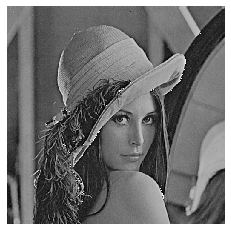

Final Result Clipped:


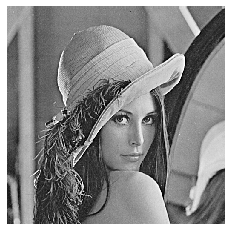

In [3]:
display_2()

To answer this question, I first created a blurred version of the original image. I then used this image to create a mask that was then added to the original image to sharpen the image. I then displayed the image with three different techniques of keeping the intensity values between 0 and 255.

From the above results, we can clearly see that simply truncating the values outside of the interval will lead to imperfections in the result due to intenities being on the complete opposite of the spectrum that they are supposed to be. Scaling the result leads to a much more clean image, but since we are adding, scaling the image will result in a lower intensity for all of the scaled values in the result. I found that clipping the values into the uint8 range lead to a much clearer image that was far more true to the original image's intensities.

## Question 3

### Nearest Neighbour

Scale = 3.1
Starting Nearest Neighbour
Done resizing


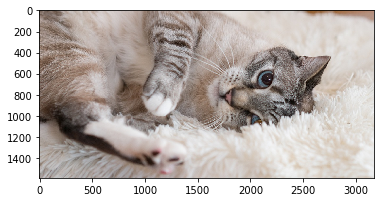

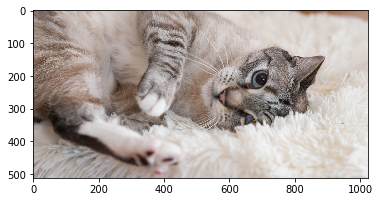

Scale = 5
Starting Nearest Neighbour
Done resizing


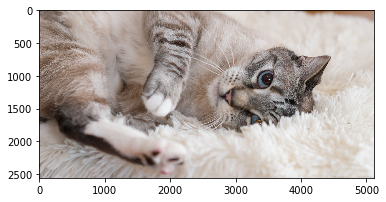

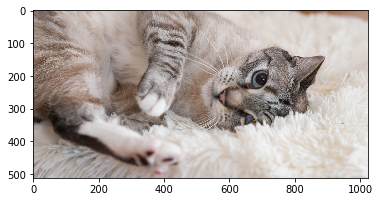

Scale = 0.9
Starting Nearest Neighbour
Done resizing


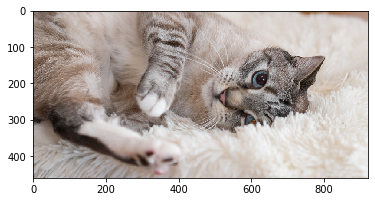

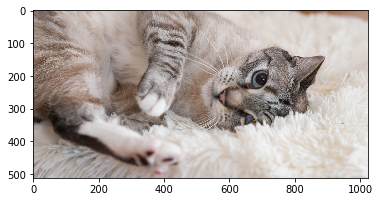

Scale = 0.1
Starting Nearest Neighbour
Done resizing


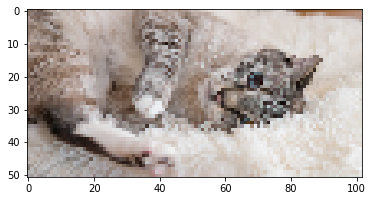

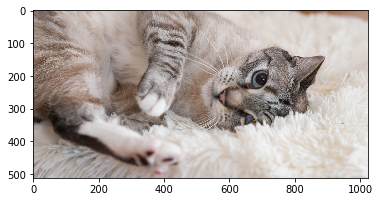

In [4]:
cat_nn = display_3_nn()

### Bilinear Interpolation

Scale = 3.1
Starting Bilinear Interpolation
Done resizing


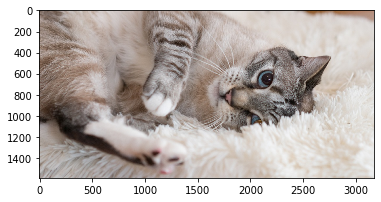

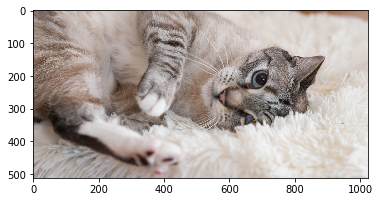

Scale = 5
Starting Bilinear Interpolation
Done resizing


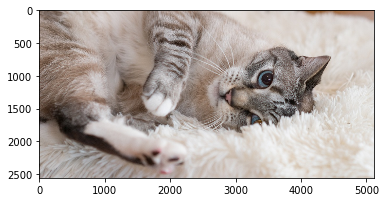

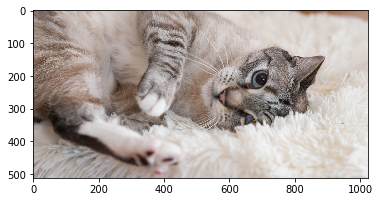

Scale = 0.9
Starting Bilinear Interpolation
Done resizing


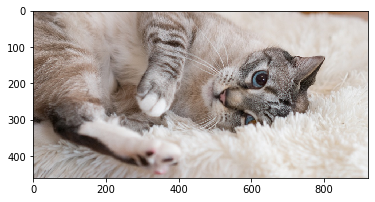

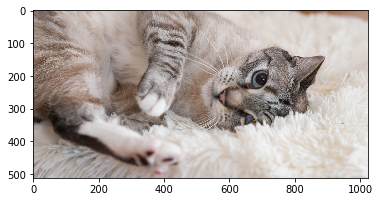

Scale = 0.1
Starting Bilinear Interpolation
Done resizing


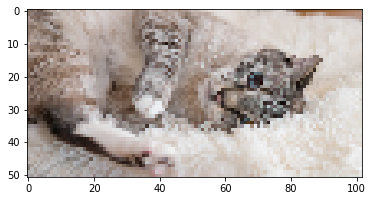

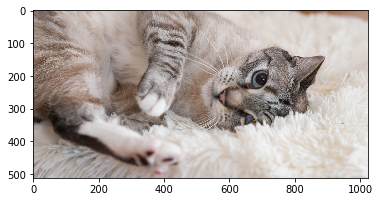

In [5]:
cat_bl = display_3_bl()

### Comparison
To compare how the two methods of interpolation result in very different final images, we will take the eyeball of this cat after being scaled by x3.1.

Nearest Neighbour Interpolation:


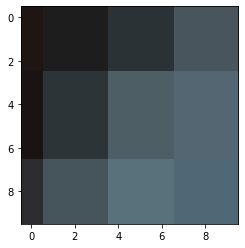

Bilinear Interpolation:


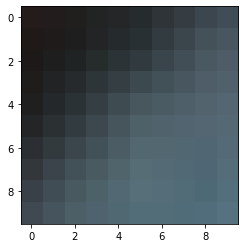

Open CV resize:


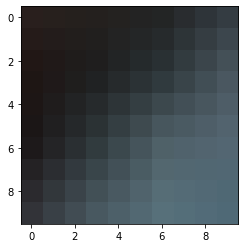

In [6]:
compare_nn_bl()

From the above comparissons, we can see that the nearest neighbour interpolation creates a far more general impression of a neighbourhood than the bilinear interpolation. This means that bilinear interpolation gives us a far better quality of image with more detail. We can see that the built in OpenCV resizing algorithm returns a result that is far closer to the bilinear interpolation result than the nearest neighbour interpolation. This is most likely because the OpenCV algotithm and bilinear interpolation both take the position of the inverse pixel far more seriously than nearest neighbour interpolation, which results in different values for most pixels in a neighbourhood, rather than clumping a neighbourhood as a single colour.

## Question 4a


I have chosen to use the python OpenCV library to answer this question.

### (1)
first I created a function that returns an image, its feature coordinates as keypoints and the descriptors using the cv2 detectAndCompute function. This function requires the chosen feature detector algorithm and the image to be analysed. This allowed me to test different detector algorithms.

### (2)
I then created functions to find and draw the feature vectors between two input images, using a given feature detector algorithm.


For ORB I used a brute force matcher using NORM_HAMMING for the norm, and True crossCheck, as is recomended by the OpenCV documentation. Such technique usually produces best results with minimal number of outliers when there are enough matches.

These are the resources from the OpenCV documenation that I used to learn about about ORB and how to use it:

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html#orb
https://docs.opencv.org/3.4.2/d5/dde/tutorial_feature_description.html

For SURF I used BruteForce-L2 for the descriptor matcher type and set the hessian threshold at 400 to start with as was suggested by the examples in the OpenCV documentation.

These are the resources from the OpenCV documenation that I used to learn about about SURF and how to use it:

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html#surf
https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html

## Question 4b
I then tested my program with various different algorithms in inputs to find the best and most correct possible result.

SURF, min hessian = 400
Matching features: 2182


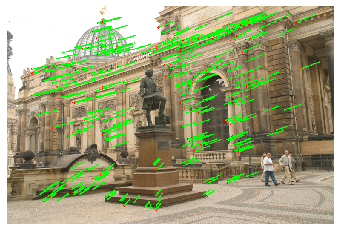

ORB
Matching features: 292


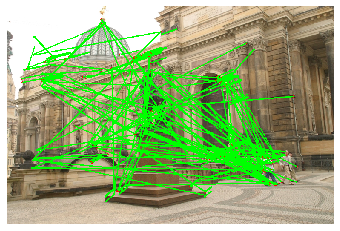

In [7]:
display_4_2()

Above we can see, in the 300 closest matches (by distance between points on semper0), that in the SURF example, there are far more matches than in the ORB example. More importantly there are far more matches that look as if they are correct. It is for that reason that I chose the SURF algorithm.

SURF, min hessian = 400
Matching features: 2182


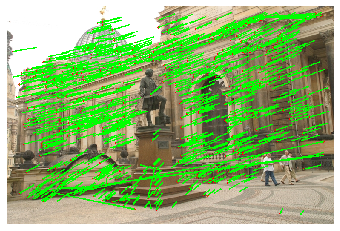

SURF, min hessian = 300
Matching features: 2588


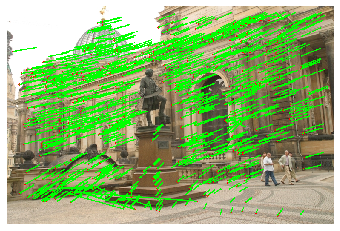

SURF, min hessian = 200
Matching features: 3240


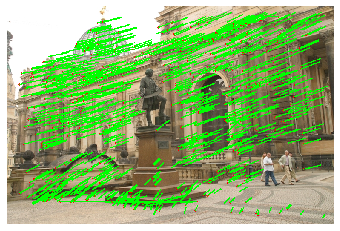

SURF, min hessian = 100
Matching features: 4280


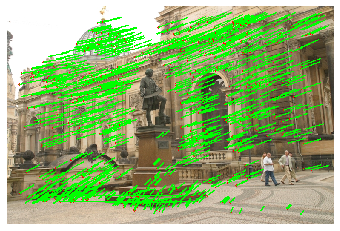

SURF, min hessian = 50
Matching features: 5006


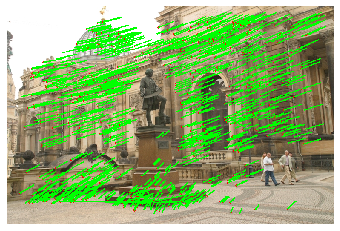

In [8]:
change_hessian(1000)

In the above examples, I have decremented the hessian threshold to try and find a point where incorrect matches start to appear. to illustrate this I have drawn the first 1000 matching feature vectors that have the shortest distance between the two images.

It is clear that 400 is too high of a threshold, but there is no clear improvement when the threshold is lower than 100. I have therefore chosen the hessian threshold as 100.

## Question 5

To answer this question, I used the OpenCV built in resizing algorithm to create 13 differently scaled images between 0.1 and 3.0. I then ran my program on them to test its robustness.

Resizing:


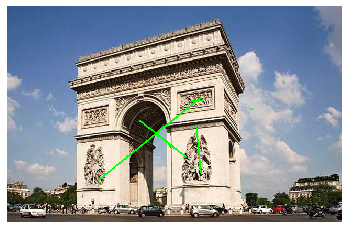

1% distance threshold: 6.4
Matching features: 6
Correct Matches: 2
Scale: 0.1
Repeatability:0.26490066225165565%
Accuracy: 33.33333333333333%
**************


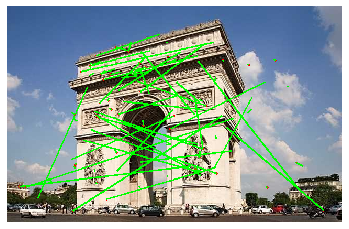

1% distance threshold: 6.4
Matching features: 84
Correct Matches: 30
Scale: 0.2
Repeatability:3.708609271523179%
Accuracy: 35.714285714285715%
**************


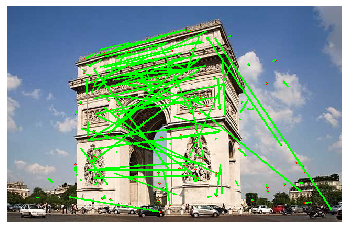

1% distance threshold: 6.4
Matching features: 228
Correct Matches: 100
Scale: 0.30000000000000004
Repeatability:10.066225165562914%
Accuracy: 43.859649122807014%
**************


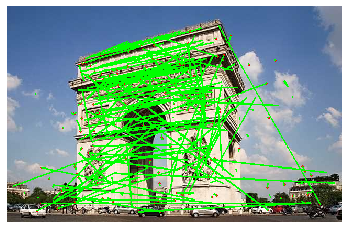

1% distance threshold: 6.4
Matching features: 409
Correct Matches: 197
Scale: 0.4
Repeatability:18.05739514348786%
Accuracy: 48.16625916870416%
**************


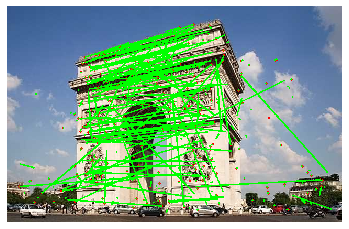

1% distance threshold: 6.4
Matching features: 571
Correct Matches: 363
Scale: 0.5
Repeatability:25.20971302428256%
Accuracy: 63.57267950963222%
**************


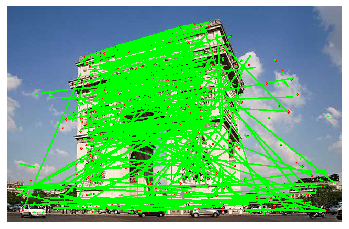

1% distance threshold: 6.4
Matching features: 896
Correct Matches: 422
Scale: 0.6
Repeatability:39.558498896247244%
Accuracy: 47.098214285714285%
**************


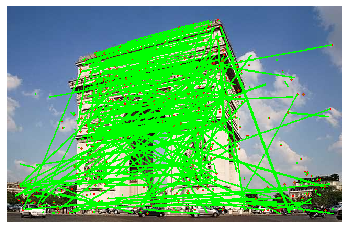

1% distance threshold: 6.4
Matching features: 1128
Correct Matches: 647
Scale: 0.7000000000000001
Repeatability:49.80132450331126%
Accuracy: 57.35815602836879%
**************


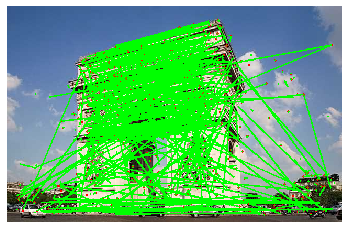

1% distance threshold: 6.4
Matching features: 1417
Correct Matches: 765
Scale: 0.8
Repeatability:62.56070640176601%
Accuracy: 53.98729710656316%
**************


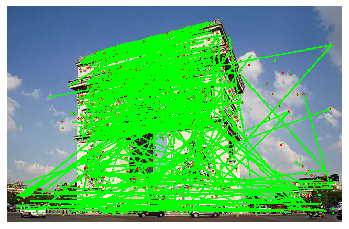

1% distance threshold: 6.4
Matching features: 1767
Correct Matches: 1021
Scale: 0.9
Repeatability:78.01324503311258%
Accuracy: 57.7815506508206%
**************


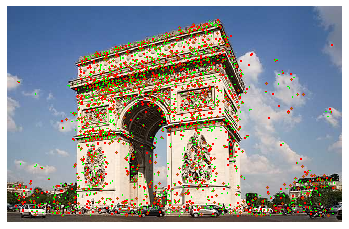

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 2265
Scale: 1.0
Repeatability:100.0%
Accuracy: 100.0%
**************


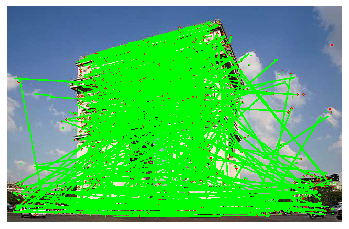

1% distance threshold: 6.4
Matching features: 2224
Correct Matches: 1291
Scale: 1.1
Repeatability:98.18984547461369%
Accuracy: 58.048561151079134%
**************


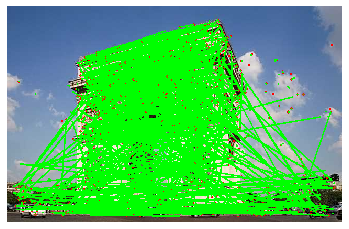

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1198
Scale: 1.2000000000000002
Repeatability:100.0%
Accuracy: 52.89183222958057%
**************


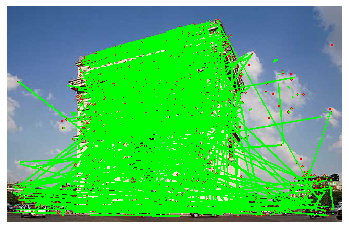

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1234
Scale: 1.3000000000000003
Repeatability:100.0%
Accuracy: 54.48123620309051%
**************


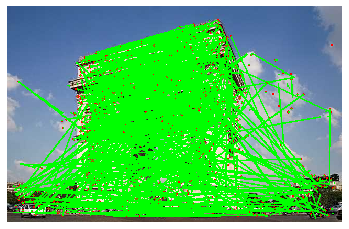

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1264
Scale: 1.4000000000000001
Repeatability:100.0%
Accuracy: 55.80573951434879%
**************


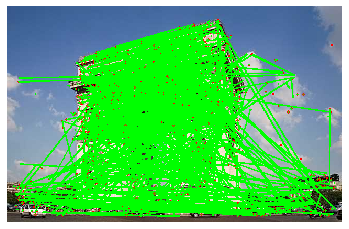

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1240
Scale: 1.5000000000000002
Repeatability:100.0%
Accuracy: 54.746136865342166%
**************


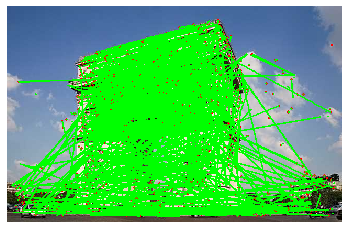

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1204
Scale: 1.6
Repeatability:100.0%
Accuracy: 53.15673289183223%
**************


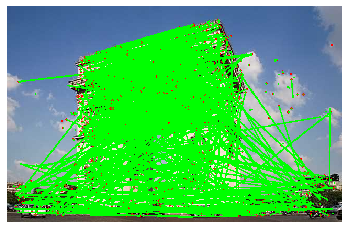

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1158
Scale: 1.7000000000000002
Repeatability:100.0%
Accuracy: 51.12582781456953%
**************


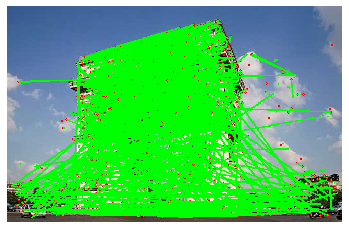

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1153
Scale: 1.8000000000000003
Repeatability:100.0%
Accuracy: 50.905077262693155%
**************


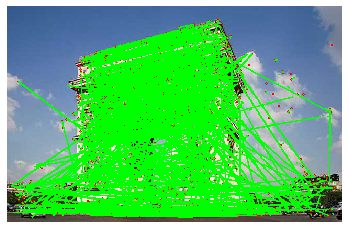

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1297
Scale: 1.9000000000000001
Repeatability:100.0%
Accuracy: 57.262693156732894%
**************


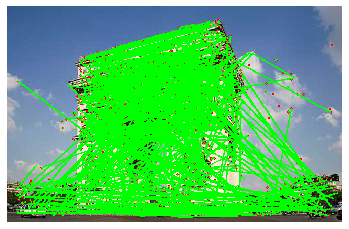

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1443
Scale: 2.0
Repeatability:100.0%
Accuracy: 63.70860927152317%
**************


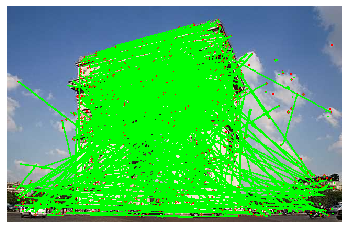

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1286
Scale: 2.1
Repeatability:100.0%
Accuracy: 56.77704194260485%
**************


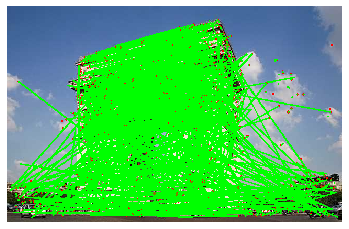

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1142
Scale: 2.2
Repeatability:100.0%
Accuracy: 50.41942604856512%
**************


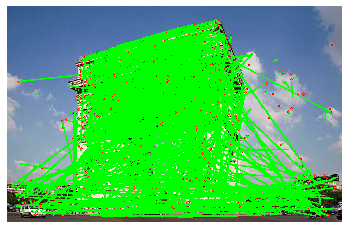

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1081
Scale: 2.3000000000000003
Repeatability:100.0%
Accuracy: 47.726269315673285%
**************


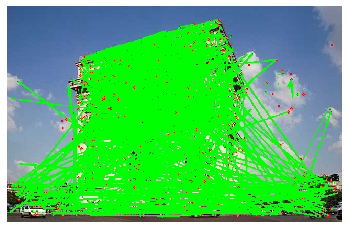

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1078
Scale: 2.4000000000000004
Repeatability:100.0%
Accuracy: 47.59381898454746%
**************


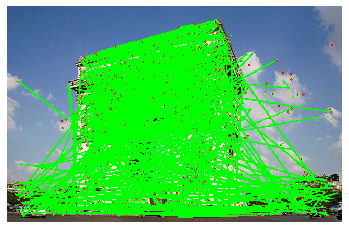

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1148
Scale: 2.5000000000000004
Repeatability:100.0%
Accuracy: 50.68432671081678%
**************


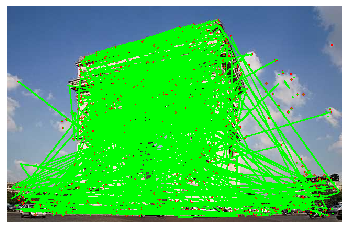

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1204
Scale: 2.6
Repeatability:100.0%
Accuracy: 53.15673289183223%
**************


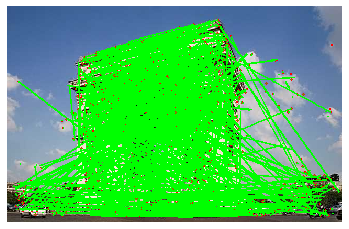

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1226
Scale: 2.7
Repeatability:100.0%
Accuracy: 54.128035320088294%
**************


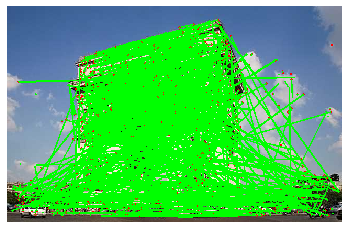

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1217
Scale: 2.8000000000000003
Repeatability:100.0%
Accuracy: 53.73068432671082%
**************


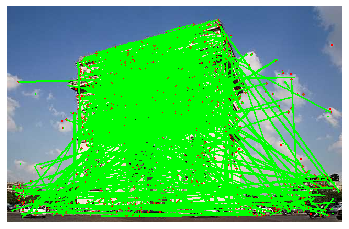

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1265
Scale: 2.9000000000000004
Repeatability:100.0%
Accuracy: 55.84988962472406%
**************


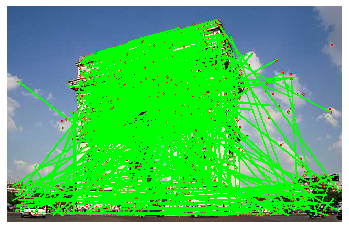

1% distance threshold: 6.4
Matching features: 2265
Correct Matches: 1251
Scale: 3.0000000000000004
Repeatability:100.0%
Accuracy: 55.2317880794702%
**************


In [9]:
accuracy_list, repeatability_list, scales = display_5()

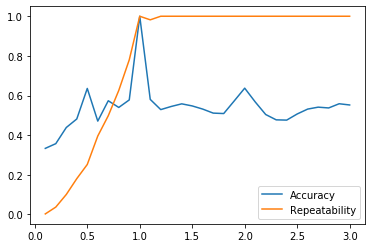

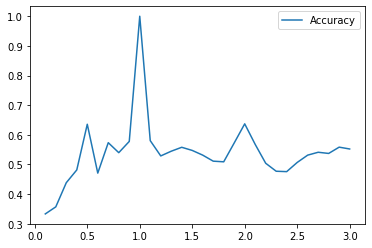

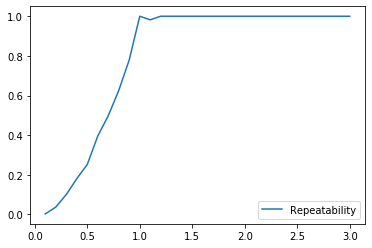

In [10]:
plot_5()

From the above experiment, we can see that the repeatability of the matching is very low on the smaller images. This is due to the fact that with fewer pixels, the algorithm will struggle to find as many feature points to match with feature points in the original image. We can see that as the scale increases, the repeatability increases and finally flatlines at 100%. This is due to the fact that at larger scales there are far more features to be found in images due to the much larger amount of detail created by the larger pixel count. Eventually there are more features being found in the scaled images than the original image, which leads to there always being a match for every feature in the original image, even if the matches are not exactly correct.


The accuracy of the algorithm reacts completely differently to the repeatability. At the lower scales, we can see that the accuracy is tiny, which is expected due to so much detail being lost when the original image is scaled. After the feature detection alogorithms are able to find enough feature points to make real comparissions the accuracy (which was allowed 1% leeway) is consistantly in the range of 45%-65%.


These results look like this because this particular implementation is looking for as many feature matches as it can possibly find, regardless of the positioning. this is necessary as it increases the repeatability for when we are trying to find how an image has moved between two images, but for comparing scaled images it results in a fairly poor accuracy rate. It is possible to only match features that are correct, but this would only make the accuracy better for scaled images and would decrease the repeatability. Thsi solution would also make it compeletely useless for detecting if an picture was taken from a different angle.